## Linear Regression, Ridge Regression and Lasso

CS184A/284A Assignment 1<br>
Fall 2016


In this assignment, we will walk you through the process of implementing
- Linear regression
- Gradient descent 
- Stochastic gradient descent (SGD)
- Ridge regression
- Lasso 

The purpose of this assignment is to familiarize you with basic knowledge about linear regression, including optimization and cross-validation, and help you gain proficiency in writing efficient code.

** Please don't add or remove any code cells, as it might break our automatic grading system and affect your grade. **


## Instructions on submission

- Once you download the ipython notebook file, change its name to:   ps1-(YOUR UCINetID).ipynb
- Once you complete your assignment, upload ps1-(YOUR UCINetID).ipynb to EEE dropbox: CS284A PS
- Grading will be solely based on whether your code returns correct results. 
- Only add/modify code within blocks marked between "### YOUR CODE HERE" and ###

**Honor Code:** I hereby agree to abide the UCI Honor Code and that of the Computer Science Department, promise that the submitted assignment is my own work, and understand that my code is subject to plagiarism test.

**Signature**: *(Stanislav Listopad)*

In [10]:
# Run some setup code for this notebook. Don't modify anything in this cell.
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6)
import random
from sklearn import linear_model
from sklearn import datasets, linear_model, cross_validation, metrics
random.seed(1)

## Diabetes dataset

The diabetes dataset consists of 10 physiological variables (age, sex, weight, blood pressure) measure on 442 patients, and an indication of disease progression after one year. 

The physiological variables will be called *features*.  So we have $n=10$ features for this dataset.

In [11]:
# load the diabetes dataset
diabetes = datasets.load_diabetes()   # (m=442, n=10)
diabetes_X = diabetes.data  #  features
diabetes_y = diabetes.target  #  output 

In [12]:
# check the size of the data
print diabetes_X.shape
print diabetes_y.shape

(442L, 10L)
(442L,)


## 1 Data preprocessing

### 1.1 Normalize features such that the mean and variance of each feature across all samples is 0 and 1, respectively.  

- Given an input matrix of *m* rows and *n* columns, compute the noramlized data matrix. That is, when the input is

      [[1,2],
      [2,3],
      [3,4]]
    
the output of your functions should be

    [[-1.22474487, -1.22474487],
    [0., 0.]]
    [1.22474487  1.22474487]]
    
- Since each feature is represented by one column, we need to normalize each column of the data matrix to be mean 0 and variance 1.     

In [13]:
# Implement a function that normalizes each column of a matrix to have zero mean and 1 std. 
def normalizeCols(x):
    """ Column normalization function """
    
    ### YOUR CODE HERE
    
    #Check if x is a matrix or a vector
    if (x.shape[0] != x.size):
        #if the intput is a matrix process it accordingly
        indexRows = 0
        indexColumns = 0
        columnMeans = [];
        for column in x.T:
            #calculate the mean of each column & substract it from each value in that column
            columnSum = 0
            for value in column:
                columnSum = columnSum + value
            columnMean = columnSum / len(column)
            columnMeans.append(columnMean)
            for value in column:
                x[indexRows, indexColumns] = value - columnMean
                indexRows += 1
            indexColumns += 1
            indexRows = 0
        indexColumns = 0

        for column in x.T:
            #calculate the standard deviation (SD) of each column & divide each value in that column by the column's SD
            columnVarianceSum = 0
            for value in column:
                columnVarianceSum += (value)**(2)
            SD = (columnVarianceSum / len(column))**(0.5)
            for value in column:
                x[indexRows, indexColumns] = value/SD
                indexRows += 1
            indexColumns += 1
            indexRows = 0
    else:
        #if the input is a vector process it accordingly
        #calculate the mean of the vector & substract it from each value of the vector
        columnSum = 0
        for value in x:
            columnSum = columnSum + value
        columnMean = columnSum / len(x)
        index = 0
        for value in x:
            x[index] = value - columnMean
            index += 1
        #calculate the standard deviation (SD) of the vector & divide each value of the vector by SD
        columnVarianceSum = 0
        for value in x:
            columnVarianceSum += (value)**(2)
        SD = (columnVarianceSum / len(x))**(0.5)
        index = 0
        for value in x:
            x[index] = value/SD
            index += 1
            
    ### END YOUR CODE
    
    return x

# Test this function
print "=== For autograder ==="
print normalizeCols(np.array([[1.,2.],[2, 3],[3,4]]))  
# the result should be [[-1.22474487 -1.22474487] [ 0.          0.        ] [ 1.22474487  1.22474487]]

=== For autograder ===
[[-1.22474487 -1.22474487]
 [ 0.          0.        ]
 [ 1.22474487  1.22474487]]


In [14]:
# normalize the input data
diabetes_X_scale = normalizeCols(diabetes_X)
diabetes_y_scale = normalizeCols(diabetes_y)

### 1.2 Next we augement the feature matrix by adding a constant to the first column

That is, given a matrix 
$$\begin{bmatrix}x_{11} & x_{12}\\ x_{21} & x_{22}\end{bmatrix}$$ we want to generate a new one
$$\begin{bmatrix}1 & x_{11} & x_{12}\\ 1& x_{21} & x_{22}\end{bmatrix}$$

In [15]:
# add a constant of 1 to the first column of a matrix
def add_constant(x):
    """ Add a column of constant 1 """
    ### YOUR CODE HERE
    z = np.ones((x.shape[0], 1))
    x = np.append(z, x, axis = 1)
    
    ### END YOUR CODE
    return x

# Test this function
print "=== For autograder ==="
print add_constant(np.array([[1.,2.],[2, 3],[3,4]]))  

=== For autograder ===
[[ 1.  1.  2.]
 [ 1.  2.  3.]
 [ 1.  3.  4.]]


In [16]:
diabetes_X_scale_aug = add_constant(diabetes_X_scale)

In [17]:
# split the data into traing and testing
# model parameters will be trained based on training data only
# performance of the model will be evaluated based on test data

diabetes_X_train, diabetes_X_test, diabetes_y_train, diabetes_y_test = cross_validation.train_test_split(\
                        diabetes_X_scale_aug, diabetes_y_scale, test_size=0.5, random_state=0)

##  2 Use linear regression to model the data
 $$y = X\theta + \epsilon$$

- $X$: Data
- $y$: Target variable
- $\theta$: Coefficients
- $\epsilon$: Observation noise

We will walk through two methods for finding the optimal parameter $\theta$. 

## 2.1 Find the least square solution through the normal equation

$$X^TX \theta = X^T y$$

Hint : Use *numpy.linalg.solve(a, b)* function to solve $ax = b$

In [18]:
def solve_normal_equation(X, y):
    """ find the least square solution of X theta = y """
    ### YOUR CODE HERE
    xt = np.transpose(X)
    X = np.dot(xt, X)
    y = np.dot(xt, y)
    theta = np.linalg.solve(X, y)

    ### END YOUR CODE
    return theta

# Test this function
print "=== For autograder ==="
print solve_normal_equation(np.array([[1.,2.],[2, 3],[3,4]]), np.array([1,1,-1]))  
# should produce [-3.33333333  2.33333333]

=== For autograder ===
[-3.33333333  2.33333333]


In [19]:
# now compute coeficents of the linear fit on the diabetes dataset
theta_normal = solve_normal_equation(diabetes_X_train, diabetes_y_train)
print theta_normal

[ 0.02890049 -0.01260771 -0.16423326  0.34877381  0.20109076 -0.4275837
  0.24436934  0.01453353  0.07188042  0.52131379  0.00785681]


## Define a score function to evaluate the goodness-of-fit of the linear model 

- We will use **$r^2$** to measure the goodness-of-fit 
- Use function score() to measure the goodness-of-fit of the linear model

In [20]:
# compare r2 of the model
def r2(y_obs, y_pred):
    return 1-np.sum((y_obs-y_pred)**2) / np.sum(( y_obs-y_obs.mean())**2)

# score the performance of linear regression using r2
def score(X, y, theta):
    return r2(y, X.dot(theta))

In [21]:
# Test this function
print "=== For autograder ==="
score(diabetes_X_test, diabetes_y_test, theta_normal)

# should return  0.43774922562451557

=== For autograder ===


0.43774922562451557

## 2.2 Gradient descent

Next we walk through steps of implementing gradient descent algorithm

## Compute mean square error cost between model outputs and observations

Given $X$, $y$, and $\theta$, where maxtrix $X$ is of $m$ by $n+1$,  

* the mean square cost is defined to be

$$J(\theta) = \frac{1}{2m}\|X\theta - y\|^2$$

* the gradient of $J(\theta)$ w.r.t. $\theta$ is
$$\nabla J(\theta) = \frac{1}{m} X^T(X\theta-y)$$

** Now define a function which receives $X$, $y$, $\theta$ as input and outputs both cost and gradient** 

In [22]:
def linear_regression_cost_grad(X, y, theta):
    # calculate cost and grad of mean square error cost function
    # X:  m x (n+1)  (m: number of samples, n: number of feature dimension)
    # y:  m x 1  (target)
    # beta: (n+1),   (beta_0 is the intercept)
    # output: cost, grad   where grad should be an one-dimensional array with size n+1. 
    
    ### YOUR CODE HERE
    x_1 = np.dot(X, theta)
    x_2 = np.subtract(x_1, y)
    x_3 = np.square(x_2)
    x_4 = np.sum(x_3)
    m = X.shape[0]
    cost = (1.0/(2*m)) * x_4
    
    x_5 = np.transpose(X)
    x_6 = np.multiply((1.0/m), x_5)
    grad = np.dot(x_6, x_2)
    
    ### END YOUR CODE
    
    return cost, grad

# Test this function
print "=== For autograder ==="
print linear_regression_cost_grad(np.array([[1.,2.],[2, 3],[3,4]]), np.array([1,1,-1]), np.array([1,1]))  
# should produce (14.0, array([ 11.33333333,  16.        ]))

=== For autograder ===
(14.0, array([ 11.33333333,  16.        ]))


In [23]:
# compute cost and grad with the normal equation returned parameters
linear_regression_cost_grad(diabetes_X_train, diabetes_y_train, theta_normal)

# the cost should be 0.22985092280091579
# grad should be all zeros. 

(0.22985092280091557,
 array([ -5.89604028e-18,   3.07126221e-16,  -1.33707650e-16,
          4.72426471e-17,  -1.33371521e-16,   2.38338028e-16,
         -4.86775990e-16,   6.49623168e-17,   6.52042284e-17,
          1.28435723e-16,  -1.28240712e-16]))

### 2.2.1 Implement gradient descent algorithm

In [24]:
def sgd(f, x0, step, iterations, PRINT_EVERY=10):
    """ Stochastic Gradient Descent """
    ###################################################################
    # Implement the stochastic gradient descent method in this        #
    # function.                                                       #
    # Inputs:                                                         #
    #   - f: the function to optimize, it should take a single        #
    #        argument and yield two outputs, a cost and the gradient  #
    #        with respect to the arguments                            #
    #   - x0: the initial point to start SGD from                     #
    #   - step: the step size for SGD                                 #
    #   - iterations: total iterations to run SGD for                 #
    #   - PRINT_EVERY: specifies every how many iterations to output  #
    # Output:                                                         #
    #   - x: the parameter value after SGD finishes                   #
    ###################################################################
    
    # Anneal learning rate every several iterations
    #
    ANNEAL_EVERY = 10000    

    x = x0    
    cost = 0
    for iter in xrange(iterations):

        ### YOUR CODE HERE        
        cost, gradient = f(x)
        x = x - step * gradient
        
        ### END YOUR CODE      
        
        if iter % PRINT_EVERY == 0:
            print "iter: %d cost: %f" % (iter, cost)               
      
        if iter % ANNEAL_EVERY == 0:
            step *= 0.5
            
        #plt.plot(iter, cost, '.b')            
    return x

# Test this function
print "=== For autograder ==="
# test gradient descent on a simple quadratic function
quad = lambda x: (np.sum(x ** 2), x * 2)
sgd(quad, 2.5, 0.1, 100)

=== For autograder ===
iter: 0 cost: 6.250000
iter: 10 cost: 0.600379
iter: 20 cost: 0.072992
iter: 30 cost: 0.008874
iter: 40 cost: 0.001079
iter: 50 cost: 0.000131
iter: 60 cost: 0.000016
iter: 70 cost: 0.000002
iter: 80 cost: 0.000000
iter: 90 cost: 0.000000


5.902533086130547e-05

The output of the previous cell should be 
~~~
=== For autograder ===
iter: 0 cost: 6.250000
iter: 10 cost: 0.600379
iter: 20 cost: 0.072992
iter: 30 cost: 0.008874
iter: 40 cost: 0.001079
iter: 50 cost: 0.000131
iter: 60 cost: 0.000016
iter: 70 cost: 0.000002
iter: 80 cost: 0.000000
iter: 90 cost: 0.000000
5.902533086130547e-05
~~~

## 2.2.2 Next we run batch gradient descent on the diabetes training data

In [25]:
# set up parameters for running sgd,  do not change these parameters
np.random.seed(1)
theta0 = np.random.randn(diabetes_X_train.shape[1],)  # randomly initialize theta
step = 0.1     # step size
niter = 5000   # number of iterations

## Now run gradient descent on the diabetes training data using linear_regression_cost_grad

### YOUR CODE HERE
index = 0
while (index < niter):
    cost, grad = linear_regression_cost_grad(diabetes_X_train, diabetes_y_train, theta0)
    theta0 = np.subtract(theta0, np.multiply(step, grad))
    index += 1
theta_batch = theta0
### END YOUR CODE

In [26]:
# Test this function
print "=== For autograder ==="
print linear_regression_cost_grad(diabetes_X_train,diabetes_y_train, theta_batch)
# should return (0.22999125339269705, ....)

=== For autograder ===
(0.22985227260915433, array([  3.98144947e-07,  -8.83067362e-07,  -6.33262024e-08,
        -2.14838763e-06,   1.11892519e-06,  -1.12273791e-04,
         8.87753217e-05,   5.06747668e-05,   1.58268768e-05,
         4.18336656e-05,  -2.23395432e-07]))


## 2.2.3 Next we run stochastic gradient descent on the diabetes training data

In [27]:
# wrapper for choosing minibatches
def sgd_wrapper(X, y, params, modelCostAndGradient, batchsize = 50):
    """ wrapper for calling stochastic gradient descent"""
    if len(X.shape) < 2:
        X = X.reshape(-1,1)
        
    C = X.shape[0]
    
    # randomly sample minibatch
    if batchsize < C:
        index = random.sample(range(0,C), batchsize)
        X = X[index,:]
        y = y[index]
    
    cost, grad = modelCostAndGradient(X, y, params)        
    return cost, grad

In [28]:
# set up parameters for running sgd,  do not change these parameters
np.random.seed(1)
theta0 = np.random.randn(diabetes_X_train.shape[1],)  # randomly initialize theta
step = 0.1     # step size
niter = 5000  # number of iterations
batchsize = 50  # mini batch size

## Now run gradient descent on the diabetes training data using linear_regression_cost_grad and sgd_wrapper

### YOUR CODE HERE   
index = 0
while (index < niter):
    cost, grad = sgd_wrapper(diabetes_X_train, diabetes_y_train, theta0, linear_regression_cost_grad)
    theta0 = np.subtract(theta0, np.multiply(step, grad))
    index += 1
theta_sgd = theta0
### END YOUR CODE

In [29]:
# Test this function
print "=== For autograder ==="
print linear_regression_cost_grad(diabetes_X_train,diabetes_y_train, theta_sgd)
# should return (0.23065788930966591, ...)

=== For autograder ===
(0.23145410910655287, array([-0.02101056, -0.00818933, -0.00312853,  0.02317685,  0.00662132,
        0.02550392,  0.03914067, -0.03680066,  0.0432925 ,  0.01604462,
        0.01163812]))


## Regulariation techniques

## 3. Ridge regression

- Regularize L2 norm of coeficents.  Shrink the coeficents toward zero. 

- Cost function: $$ J(\theta) =  \frac{1}{2m}\|X\theta - y\|^2 + \alpha \|\theta\|_2^2 $$

* $\alpha$ is the regularization parameter

In [30]:
def solve_ridge_normal_equation(X, y, alpha):
    """ find the solution of ridge regression through linear equations """
    
    ### YOUR CODE HERE

    X_t = np.transpose(X)
    X_ty = np.dot(X_t, y)
    X_tX = np.dot(X_t, X)
    m = X.shape[0]
    I = np.identity(X_tX.shape[0])
    m_alpha_I = np.dot(m*alpha, I)
    x_1 = np.add(X_tX, m_alpha_I)
    x_2 = np.linalg.inv(x_1)
    theta = np.dot(x_2, X_ty)
    
    ### END YOUR CODE
    
    return theta

# Test this function
print "=== For autograder ==="
print solve_ridge_normal_equation(np.array([[1.,2.],[2, 3],[3,4]]), np.array([1,1,-1]), 1.5)  
# should return [-0.09101251  0.08418658]

=== For autograder ===
[-0.09101251  0.08418658]


In [31]:
# now implement a function that compute the cost and gradient of the ridge cost function
def ridge_regression_cost_grad(X, y, theta, alpha):
    # calculate cost and grad of mean square error cost function
    # X:  m x (n+1)  (m: number of samples, n: number of feature dimension)
    # y:  m x 1  (target)
    # beta: (n+1),   (beta_0 is the intercept)
    # alpha: scalar
    # output: cost, grad   where grad should be an one-dimensional array with size n+1. 
    
    ### YOUR CODE HERE
    m = X.shape[0]
    alpha_theta = alpha * (np.linalg.norm(theta, 2)**2)
    X_theta = np.dot(X, theta)
    X_theta_y = np.subtract(X_theta, y)
    X_theta_y2 = np.square(X_theta_y)
    x_1 = (np.linalg.norm(X_theta_y2, 1))/(2*m)
    cost = x_1 + alpha_theta
    
    X_t = np.transpose(X)
    x_2 = np.dot((1.0/m), X_t)
    x_3 = np.dot(x_2, X_theta_y) 
    grad = np.add(x_3, np.dot((1*alpha), theta))
    ### END YOUR CODE
    
    return cost, grad

# Test this function
print "=== For autograder ==="
print ridge_regression_cost_grad(np.array([[1.,2.],[2, 3],[3,4]]), np.array([1,1,-1]), np.array([1,1]), 1.5)  
# should produce (17.0, array([ 12.83333333,  17.5       ]))

=== For autograder ===
(17.0, array([ 12.83333333,  17.5       ]))


## Choose regularization parameter $\alpha$ through cross-validation

In [32]:
# split the training data into training and validation
X_train, X_val, y_train, y_val = cross_validation.train_test_split(\
                        diabetes_X_train, diabetes_y_train, test_size=0.2, random_state=0)

alpha: 0.000000,  score: 4.038617
alpha: 0.111111,  score: 4.108495
alpha: 0.222222,  score: 4.187895
alpha: 0.333333,  score: 4.227773
alpha: 0.444444,  score: 4.240125
alpha: 0.555556,  score: 4.233933
alpha: 0.666667,  score: 4.215412
alpha: 0.777778,  score: 4.188811
alpha: 0.888889,  score: 4.157033
alpha: 1.000000,  score: 4.122068
=== For autograder ===
Best alpha is:  0.444444444444


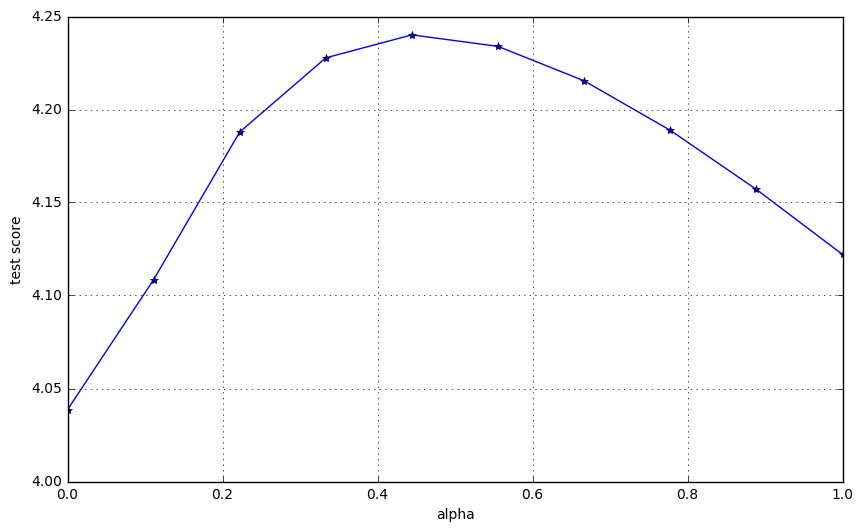

In [33]:
alphas = np.linspace(0, 1, 10)
scores = []

for alpha in alphas:
    
    ### YOUR CODE HERE
    #train theta using ridge regression with alpha_n
    np.random.seed(1)
    theta0 = np.random.randn(X_train.shape[1],)  # randomly initialize theta
    step = 0.1     # step size
    niter = 5000  # number of iterations
    
    index = 0
    while (index < niter):
        cost, grad = ridge_regression_cost_grad(X_train, y_train, theta0, alpha)
        theta0 = np.subtract(theta0, np.multiply(step, grad))
        index += 1
    theta_batch = theta0
    
    #validate theta
    cost, grad = linear_regression_cost_grad(X_val, y_val, theta_batch)
    s = 1.0 / cost
    
    
    ### END OF YOUR CODE
    print "alpha: %f,  score: %f" % (alpha, s)
    scores.append(s) 

plt.plot(alphas, scores,'*-')
plt.grid()
plt.xlabel('alpha')
plt.ylabel('test score')

# Test this function
print "=== For autograder ==="
alpha_best = alphas[np.argmax(scores)]
theta_ridge = solve_ridge_normal_equation(diabetes_X_train, diabetes_y_train, alpha_best)
print "Best alpha is: ", alpha_best
# best alpha should be 0.444444444444

##  4 Sparsity - LASSO 

- Select only informative features. Set non-informative features to 0
- Cost function: $$ J(\theta) =  \frac{1}{2m}\|X\theta - y\|^2 +  \alpha \|\beta\|_1 $$

###  4.1 Soft-thresholding function:

$$ S_\lambda(y) = \left \{ \begin{array}{ll} y-\lambda  & \mbox{if y >$\lambda$} \\
0  & \mbox{if $-\lambda \le y \le \lambda$}\\
y+\lambda  & \mbox{if y <$-\lambda$} \end{array} \right.$$


In [34]:
# Implement the soft threshoding function 
def soft_thresholding(y, th):
    """ soft thresholding function """
    # y is a scalar
    # th is the lambda
    # return S
    
    ### YOUR CODE HERE

    if (y > th):
        s = y - th
    elif (y < (-1 * th)):
        s = y + th
    else:
        s = 0
    
    ### END OF YOUR CODE
    
    return s

# Test this function
print "=== For autograder ==="
print soft_thresholding(5, 2.), soft_thresholding(-5., -6), soft_thresholding(-3., 6),
# should return 3.0 1.0 0.0

=== For autograder ===
3.0 1.0 0


## 4.2 Coordinate descent method for solving LASSO

In [35]:
# impement a function to compute Lasso cost
def lasso_cost(X, y, theta, alpha):
    # calculate lasso cost
    # X:  m x (n+1)  (m: number of samples, n: number of feature dimension)
    # y:  m x 1  (target)
    # theta: (n+1),   (beta_0 is the intercept)
    # alpha: scalar
    # output: cost
    
    ### YOUR CODE HERE

    m = X.shape[0]
    X_theta = np.dot(X, theta)
    X_theta_y = np.subtract(X_theta, y)
    X_theta_y2 = np.square(X_theta_y)
    x_1 = (np.linalg.norm(X_theta_y2, 1))/(2*m)
    alpha_theta = alpha * (np.linalg.norm(theta, 1))
    cost = x_1 + alpha_theta
    
    ### END YOUR CODE
    
    return cost

# Test this function
print "=== For autograder ==="
lasso_cost(X_train, y_train, theta_normal, 0.1)
# should return 0.43537505946702004

=== For autograder ===


0.43537505946701932

In [36]:
# Find optimal theta using coordinate descent
def solve_lasso(X, y, alpha, eps=1.e-10, MAX_ITER=1000):
    """ Coordinate descent method to solve LASSO """
    

    m,n = X.shape
    np.random.seed(1)
    theta = np.random.randn(n,)  # randomly initialize theta

    A = X.T.dot(X) 
    b = X.T.dot(y)
    
    J0 = np.infty
    J = lasso_cost(X,y,theta,alpha)

    iter = 0
    while abs(J-J0) > eps and iter < MAX_ITER:
        for i in range(n):
            
            # update theta[i] while fixing the rest of theta's
            
            ### YOUR CODE HERE
            x_1 = 1.0/(np.linalg.norm(X[:,i], 2)**2)
            #calculate beta_i
            beta = np.empty(n)
            for j in range(m):
                x_jk_theta_k = 0
                for k in range(n):
                    if(k != i):
                        x_jk_theta_k += X[j, k] * theta[k]
                beta[i] += X[j, i] * (y[j] - x_jk_theta_k)
            x_2 = soft_thresholding(beta[i], alpha * m)
            theta[i] = x_1 * x_2
            
            
            ### END YOUR CODE

        J0 = J
        J = lasso_cost(X,y,theta,alpha)
        iter += 1
        #if iter % 10 == 0:
        #    print iter, J  

    return theta

# Test this function
print "=== For autograder ==="
solve_lasso(X_train, y_train, 0.1)
# should return array([ 0.        ,  0.        , -0.02187849,  0.32944223,  0.05201554,
#        0.        ,  0.        , -0.07930051,  0.        ,  0.37312426,  0.        ])

=== For autograder ===


array([ 0.        ,  0.        , -0.02123786,  0.33151434,  0.05080917,
        0.        ,  0.        , -0.07756926,  0.        ,  0.37534135,  0.        ])

## 4.3 Use cross-validation to choose regularization parameter

alpha: 0.000000,  score: 4.031399
alpha: 0.111111,  score: 4.058675
alpha: 0.222222,  score: 3.767736
alpha: 0.333333,  score: 3.433051
alpha: 0.444444,  score: 2.988388
alpha: 0.555556,  score: 2.532242
alpha: 0.666667,  score: 2.223512
alpha: 0.777778,  score: 2.151867
alpha: 0.888889,  score: 2.151867
alpha: 1.000000,  score: 2.151867
=== For autograder ===
Best alpha is:  0.111111111111


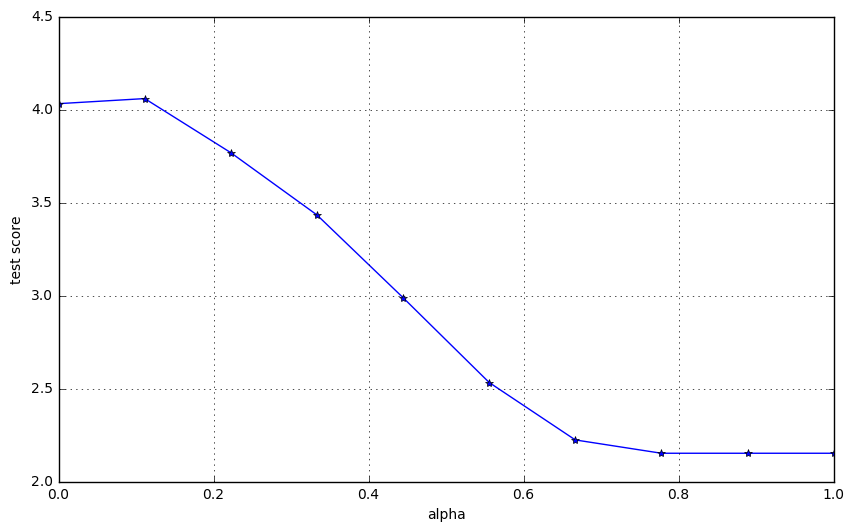

In [37]:
alphas = np.linspace(0, 1, 10)
scores = []

for alpha in alphas:
    
    ### YOUR CODE HERE
    #train theta using ridge regression with alpha_n
    np.random.seed(1)
    theta0 = np.random.randn(X_train.shape[1],)  # randomly initialize theta
    eps = 1.e-10     # step size
    niter = 1000  # number of iterations
    
    theta = solve_lasso(X_train, y_train, alpha, eps, niter)
    
    #validate theta
    cost, grad = linear_regression_cost_grad(X_val, y_val, theta)
    s = 1.0 / cost
    
    ### END OF YOUR CODE
    
    print "alpha: %f,  score: %f" % (alpha, s)
    scores.append(s) 

plt.plot(alphas, scores,'*-')
plt.grid()
plt.xlabel('alpha')
plt.ylabel('test score')

# Test this function
print "=== For autograder ==="
alpha_best = alphas[np.argmax(scores)]
theta_lasso = solve_lasso(diabetes_X_train, diabetes_y_train, alpha_best)
print "Best alpha is: ", alpha_best
# best alpha should be 0.111111111111

In [38]:
# Compare the performance of different models on test data
s1 = score(diabetes_X_test, diabetes_y_test, theta_normal)
s2 = score(diabetes_X_test, diabetes_y_test, theta_ridge)
s3 = score(diabetes_X_test, diabetes_y_test, theta_lasso)
print s1, s2, s3

# should return 0.437749225625 0.453413874731 0.427707156796
# and the winner is Ridge regression

0.437749225625 0.453413874731 0.427579726326


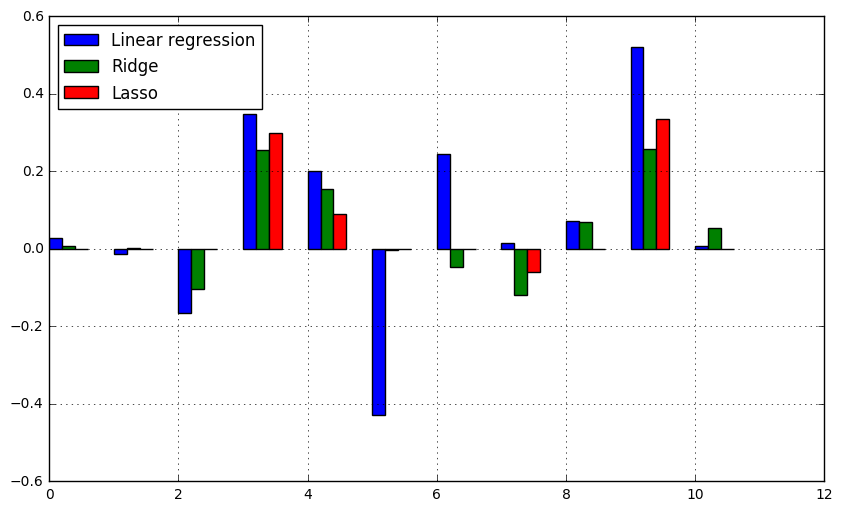

In [39]:
# plot the values of theta from three different models
plt.bar(np.arange(11),theta_normal,width=0.2,color='b')
plt.bar(np.arange(11)+0.2,theta_ridge,width=0.2,color='g')
plt.bar(np.arange(11)+0.4,theta_lasso,width=0.2,color='r')
plt.grid()
plt.legend(['Linear regression','Ridge','Lasso'],loc=2)